## Project Setup

In [2]:
# ------------------------------------------------------------------------------
# Step 0: Setup and Library Imports
# ------------------------------------------------------------------------------
# Ensure you have these libraries installed:
# !pip install pandas geopandas scikit-learn matplotlib seaborn contextily joblib xgboost requests

# Core data handling and numerical libraries
import pandas as pd
import geopandas as gpd
import numpy as np
import requests
import zipfile
import io
import os

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as cx

# Machine Learning libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.feature_selection import RFECV # New import for feature selection
import xgboost as xgb
import joblib

# To ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Set a consistent plot style
plt.style.use('seaborn-v0_8-whitegrid')
print("Libraries imported successfully.")

Libraries imported successfully.


## Fetching the Data 

In [4]:
# ------------------------------------------------------------------------------
# Step 0.5: Manually Providing Datasets
# ------------------------------------------------------------------------------
# This cell checks for the necessary data files for the analysis.
# Please place the required files in the same directory as this notebook.

print("\n--- Step 0.5: Checking for Local Datasets ---")

# INSTRUCTIONS FOR MANUAL DATA SETUP:
# 1. Census Tracts Shapefile:
#    - Download from: https://www2.census.gov/geo/tiger/TIGER2020/TRACT/tl_2020_17_tract.zip
#    - Unzip the file. This will create a folder.
#    - Place the entire unzipped folder (e.g., `tl_2020_17_tract`) in your project directory. We will refer to it as `chicago_tracts` for clarity.
#
# 2. CTA GTFS Data:
#    - Download from: https://www.transitchicago.com/downloads/sch_data/google_transit.zip
#    - Unzip the file.
#    - Place all the resulting .txt files (stops.txt, routes.txt, etc.) in your project directory.
#
# 3. TNP (Rideshare) Trips:
#    - This will be fetched automatically via an API in Step 1 to avoid large downloads. No manual setup needed for this file.


# URLs for the datasets
# 1. Census Tracts for Illinois (we will filter for Cook County/Chicago)
tracts_url = "https://www2.census.gov/geo/tiger/TIGER2020/TRACT/tl_2020_17_tract.zip"
# 2. CTA GTFS data
gtfs_url = "https://www.transitchicago.com/downloads/sch_data/google_transit.zip"


# Function to download and extract zip files
def download_and_unzip(url, extract_to='.'):
    print(f"Downloading data from {url}...")
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(path=extract_to)
    print(f"Extracted files to '{extract_to}' directory.")

# Download and extract the shapefile and GTFS
if not os.path.exists('chicago_tracts'):
    download_and_unzip(tracts_url, extract_to='chicago_tracts')
else:
    print("Tracts shapefile already downloaded.")

if not os.path.exists('stops.txt'):
    download_and_unzip(gtfs_url, extract_to='cta_gtfs')
    # Move files to root for easier access
    for item in os.listdir('cta_gtfs'):
        os.rename(os.path.join('cta_gtfs', item), item)
    os.rmdir('cta_gtfs')
else:
    print("CTA GTFS data already downloaded.")


# Check for the required files and folders
required_files = [
    'chicago_tracts/tl_2020_17_tract.shp',
    'stops.txt',
    'stop_times.txt', # Added for frequency calculation
    'trips.txt',      # Added for frequency calculation
    'calendar.txt'    # Added for frequency calculation
]
all_files_found = True
for f in required_files:
    if not os.path.exists(f):
        print(f"ERROR: Required file not found: {f}. Please follow the manual setup instructions.")
        all_files_found = False
if all_files_found:
    print("All necessary local data files found.")
    
print("TNP data will be fetched automatically if not cached.")



--- Step 0.5: Checking for Local Datasets ---
Tracts shapefile already downloaded.
CTA GTFS data already downloaded.
All necessary local data files found.
TNP data will be fetched automatically if not cached.


In [5]:
# ------------------------------------------------------------------------------
# Step 1: Data Acquisition & Loading (Real Data)
# ------------------------------------------------------------------------------
print("\n--- Step 1: Loading Real Data ---")

# Ensure 'os' is imported, typically at the top of your script
import os

# 1a. Load Geospatial Data (Census Tracts Shapefile)
gdf_tracts_full = gpd.read_file('chicago_tracts/tl_2020_17_tract.shp')
# Filter for Cook County (County FIPS code '031') which contains Chicago
gdf_tracts = gdf_tracts_full[gdf_tracts_full['COUNTYFP'] == '031'].copy()
# Use a local projected CRS for accurate measurements in Chicago
gdf_tracts = gdf_tracts.to_crs("EPSG:3435")
print(f"Loaded {len(gdf_tracts)} census tracts for Cook County.")

# 1b. Load ALL CTA GTFS Data
stops_df = pd.read_csv('stops.txt')
stop_times_df = pd.read_csv('stop_times.txt', dtype={'trip_id': str, 'stop_id': int})
trips_df = pd.read_csv('trips.txt', dtype={'trip_id': str, 'service_id': str})
calendar_df = pd.read_csv('calendar.txt', dtype={'service_id': str})
print("Loaded all GTFS files.")

gdf_stops = gpd.GeoDataFrame(
    stops_df,
    geometry=gpd.points_from_xy(stops_df.stop_lon, stops_df.stop_lat),
    crs="EPSG:4326" # Standard lat/lon CRS
).to_crs(gdf_tracts.crs) # Project to the same CRS as tracts
print(f"Loaded and projected {len(gdf_stops)} CTA stops.")

# 1c. Load TNP Data (Rideshare) with Caching
tnp_cache_path = "tnp_trips_cache.csv"

if os.path.exists(tnp_cache_path):
    print(f"Loading TNP data from local cache: {tnp_cache_path}")
    tnp_df = pd.read_csv(tnp_cache_path)
    
else:
    print("Fetching a sample of TNP trip data via API... This may take a moment.")
    try:
        soda_url = "https://data.cityofchicago.org/resource/m6dm-c72p.json"
        params = {
            "$where": "trip_start_timestamp between '2022-01-01T00:00:00.000' and '2022-03-31T23:59:59.000'",
            "$limit": 200000
        }
        response = requests.get(soda_url, params=params)
        response.raise_for_status()
        tnp_data = response.json()
        tnp_df = pd.DataFrame(tnp_data)
        
        # Save the downloaded data to the cache file
        tnp_df.to_csv(tnp_cache_path, index=False)
        print(f"Successfully loaded {len(tnp_df)} TNP trip records and saved to cache.")

    except Exception as e:
        print(f"ERROR: Could not fetch TNP data from API: {e}")
        print("Proceeding with an empty TNP dataframe.")
        tnp_df = pd.DataFrame(columns=['trip_start_timestamp', 'pickup_census_tract'])

# Rename columns for consistency
tnp_df = tnp_df.rename(columns={
    'trip_start_timestamp': 'Trip Start Timestamp',
    'pickup_census_tract': 'Pickup Census Tract'
})


--- Step 1: Loading Real Data ---
Loaded 1332 census tracts for Cook County.
Loaded all GTFS files.
Loaded and projected 11173 CTA stops.
Loading TNP data from local cache: tnp_trips_cache.csv


In [6]:
# ------------------------------------------------------------------------------
# Step 1.5: Loading Downloaded Census Data (No API Key Needed)
# ------------------------------------------------------------------------------
print("\n--- Step 1.5: Loading Census Data from Downloaded Files ---")

# INSTRUCTIONS:
# Download two files for Cook County, IL tracts from data.census.gov:
# 1. Table DP05 (Demographic)
# 2. Table DP03 (Economic)
# Unzip both, find the CSV with "_data_with_overlays_" in the name in each folder.
# Rename them to `cook_county_dp05_data.csv` and `cook_county_dp03_data.csv`.

dp05_path = 'cook_county_dp05_data.csv'
dp03_path = 'cook_county_dp03_data.csv'

if not os.path.exists(dp05_path) or not os.path.exists(dp03_path):
    print(f"WARNING: Census data files not found.")
    print("Using simulated census data. Please follow the instructions to download the real data.")
    census_df = pd.DataFrame({
        'GEO_ID': gdf_tracts['GEOID'],
        'total_pop': np.random.randint(1000, 8000, len(gdf_tracts)),
        'median_income': np.random.randint(25000, 150000, len(gdf_tracts)),
        'non_white_pop': np.random.randint(100, 4000, len(gdf_tracts)),
        'public_transit_commuters': np.random.randint(50, 500, len(gdf_tracts))
    })
else:
    print(f"Loading census data from {dp05_path} and {dp03_path}...")
    dp05_raw = pd.read_csv(dp05_path, header=1)
    dp03_raw = pd.read_csv(dp03_path, header=1)

    # UPDATED: Helper function to find column names dynamically
    def find_col_by_substrings(df, substrings):
        """Finds the full column name in a dataframe that contains all given substrings."""
        for col in df.columns:
            if all(sub in col for sub in substrings):
                return col
        return None

    # Dynamically build the variable mapping dictionaries
    dp05_vars = {'Geography': 'GEO_ID'}
    dp03_vars = {'Geography': 'GEO_ID'}
    
    # Find and add DP05 columns
    total_pop_col = find_col_by_substrings(dp05_raw, ['Estimate', 'SEX AND AGE', 'Total population'])
    if total_pop_col: dp05_vars[total_pop_col] = 'total_pop'
    
    white_pop_col = find_col_by_substrings(dp05_raw, ['Estimate', 'RACE', 'One race', 'White'])
    if white_pop_col: dp05_vars[white_pop_col] = 'white_pop'

    # Find and add DP03 columns
    median_income_col = find_col_by_substrings(dp03_raw, ['Estimate', 'Median household income'])
    if median_income_col: dp03_vars[median_income_col] = 'median_income'
    
    # NEW: Find the public transit commuters column
    public_transit_commute_col = find_col_by_substrings(dp03_raw, ['Estimate', 'COMMUTING TO WORK', 'Public transportation'])
    if public_transit_commute_col: 
        dp03_vars[public_transit_commute_col] = 'public_transit_commuters'
    else:
        print("WARNING: 'Public transportation' commute column not found in DP03 data. This feature will be skipped.")

    # Check if essential columns were found and raise an error if not
    if not median_income_col or not total_pop_col:
        raise KeyError("Could not find essential 'Median household income' or 'Total population' columns. The names in the Census CSV may have changed significantly. Please inspect the files.")

    # Select and rename columns from each dataframe
    dp05_df = dp05_raw[list(dp05_vars.keys())].rename(columns=dp05_vars)
    dp03_df = dp03_raw[list(dp03_vars.keys())].rename(columns=dp03_vars)
    
    # Merge the two dataframes on the newly created 'GEO_ID' column
    census_df = pd.merge(dp05_df, dp03_df, on='GEO_ID', how='inner')
    
    # Convert data types to numeric, coercing errors
    for col in ['total_pop', 'white_pop', 'median_income', 'public_transit_commuters']:
        if col in census_df.columns:
            census_df[col] = pd.to_numeric(census_df[col], errors='coerce')

    # Calculate non-white population
    if 'total_pop' in census_df.columns and 'white_pop' in census_df.columns:
        census_df['non_white_pop'] = census_df['total_pop'] - census_df['white_pop']
    
    print("Successfully loaded and merged local census files.")



--- Step 1.5: Loading Census Data from Downloaded Files ---
Loading census data from cook_county_dp05_data.csv and cook_county_dp03_data.csv...
Successfully loaded and merged local census files.


## Data Preprocessing 

In [8]:
# ------------------------------------------------------------------------------
# Step 2: Data Preprocessing, Merging & Service Frequency Calculation
# ------------------------------------------------------------------------------
print("\n--- Step 2: Preprocessing and Merging Data ---")

# 2a. Spatially join stops to tracts to get tract ID for each stop
gdf_stops_with_tract = gpd.sjoin(gdf_stops, gdf_tracts, how="inner", predicate='within')
stops_per_tract = gdf_stops_with_tract.groupby('GEOID').size().reset_index(name='stop_count')

# --- NEW: Calculate True Service Frequency ---
print("Calculating true service frequency from GTFS data...")
# 1. Filter for typical weekday service
weekday_service_ids = calendar_df.query('monday == 1 & tuesday == 1 & wednesday == 1 & thursday == 1 & friday == 1')['service_id']
weekday_trips = trips_df[trips_df['service_id'].isin(weekday_service_ids)]

# 2. Filter for morning peak hours (7 AM to 9 AM)
# Handle invalid time formats by coercing to NaT and dropping them
stop_times_df['arrival_time_clean'] = pd.to_datetime(stop_times_df['arrival_time'], errors='coerce').dt.time
peak_stop_times = stop_times_df.dropna(subset=['arrival_time_clean'])
peak_stop_times = peak_stop_times[
    (peak_stop_times['arrival_time_clean'] >= pd.to_datetime('07:00:00').time()) &
    (peak_stop_times['arrival_time_clean'] < pd.to_datetime('09:00:00').time())
]

# 3. Merge to find trips per stop during peak hours
peak_weekday_trips = peak_stop_times.merge(weekday_trips, on='trip_id')
trips_per_stop = peak_weekday_trips.groupby('stop_id')['trip_id'].nunique().reset_index(name='num_trips_peak')

# 4. Calculate hourly frequency (2-hour window)
trips_per_stop['service_frequency'] = trips_per_stop['num_trips_peak'] / 2

# 5. Aggregate frequency up to the census tract level
# Merge calculated frequencies onto the stops with their tract IDs
stops_with_freq = gdf_stops_with_tract.merge(trips_per_stop, on='stop_id', how='left')
stops_with_freq['service_frequency'] = stops_with_freq['service_frequency'].fillna(0)
# Calculate the AVERAGE service frequency of all stops within a tract
freq_per_tract = stops_with_freq.groupby('GEOID')['service_frequency'].mean().reset_index()
print("Service frequency calculation complete.")


# 2b. Aggregate TNP data
if not tnp_df.empty and 'Trip Start Timestamp' in tnp_df.columns:
    tnp_df.dropna(subset=['Pickup Census Tract'], inplace=True)
    tnp_df['Pickup Census Tract'] = tnp_df['Pickup Census Tract'].astype(str)
    tnp_pickups = tnp_df.groupby('Pickup Census Tract').size().reset_index(name='total_pickups')
    # Ensure datetime conversion before min/max
    tnp_df['Trip Start Timestamp'] = pd.to_datetime(tnp_df['Trip Start Timestamp'])
    num_days = (tnp_df['Trip Start Timestamp'].max() - tnp_df['Trip Start Timestamp'].min()).days
    tnp_pickups['avg_daily_pickups'] = tnp_pickups['total_pickups'] / num_days if num_days > 0 else 0
else:
    tnp_pickups = pd.DataFrame(columns=['Pickup Census Tract', 'avg_daily_pickups'])


# 2c. Merge all dataframes together
analysis_gdf = gdf_tracts.merge(stops_per_tract, on='GEOID', how='left')
analysis_gdf = analysis_gdf.merge(freq_per_tract, on='GEOID', how='left') # Merge the new frequency data
# The GEO_ID from the census file has a prefix we need to slice off
census_df['GEO_ID'] = census_df['GEO_ID'].str.split('US').str[1]
analysis_gdf = analysis_gdf.merge(census_df, left_on='GEOID', right_on='GEO_ID', how='left')
analysis_gdf = analysis_gdf.merge(tnp_pickups, left_on='GEOID', right_on='Pickup Census Tract', how='left')

# 2d. Clean up final merged data
analysis_gdf['stop_count'] = analysis_gdf['stop_count'].fillna(0)
analysis_gdf['service_frequency'] = analysis_gdf['service_frequency'].fillna(0) # Clean the new frequency column
analysis_gdf['avg_daily_pickups'] = analysis_gdf['avg_daily_pickups'].fillna(0)
analysis_gdf.rename(columns={'GEOID': 'tract_id'}, inplace=True)
analysis_gdf.dropna(subset=['total_pop', 'median_income'], inplace=True)
analysis_gdf = analysis_gdf[analysis_gdf['total_pop'] > 0]

print("Data merged and cleaned successfully.")


--- Step 2: Preprocessing and Merging Data ---
Calculating true service frequency from GTFS data...
Service frequency calculation complete.
Data merged and cleaned successfully.


## Feature Engineering 

In [10]:
# ------------------------------------------------------------------------------
# Step 3: Feature Engineering
# ------------------------------------------------------------------------------
print("\n--- Step 3: Engineering New Features ---")

# 3a. Calculate area and density features
analysis_gdf['area_sqkm'] = analysis_gdf.geometry.area / 10763910.76 # Sq Feet to Sq Km
analysis_gdf['population_density'] = analysis_gdf['total_pop'] / analysis_gdf['area_sqkm']
analysis_gdf['stop_density'] = analysis_gdf['stop_count'] / analysis_gdf['area_sqkm']

# 3b. Create percentage-based features for equity analysis
analysis_gdf['pct_minority'] = (analysis_gdf['non_white_pop'] / analysis_gdf['total_pop']) * 100

# NEW: Create a more robust feature for transit dependency
if 'public_transit_commuters' in analysis_gdf.columns:
    # Ensure we don't divide by zero
    analysis_gdf['pct_commute_public_transit'] = (analysis_gdf['public_transit_commuters'] / analysis_gdf['total_pop']).clip(0, 1) * 100
else:
    # If not, create a placeholder column so the rest of the script doesn't fail
    analysis_gdf['pct_commute_public_transit'] = 0
    print("WARNING: 'public_transit_commuters' data not available. 'pct_commute_public_transit' feature set to 0.")

print("Feature engineering complete.")


--- Step 3: Engineering New Features ---
Feature engineering complete.


## Exploratory Data Analysis (EDA)


--- Step 4: Performing Exploratory Data Analysis ---


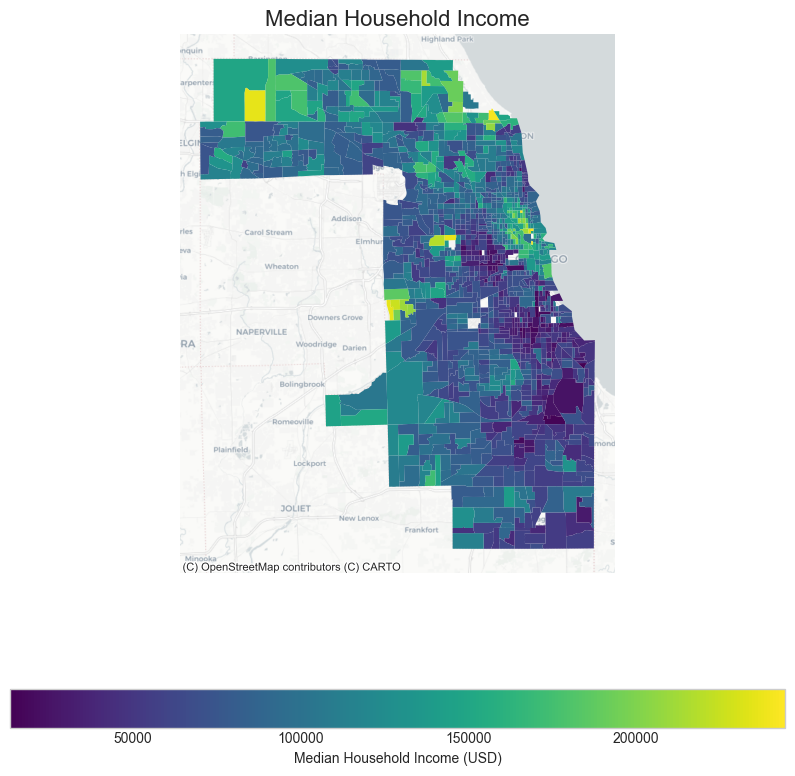

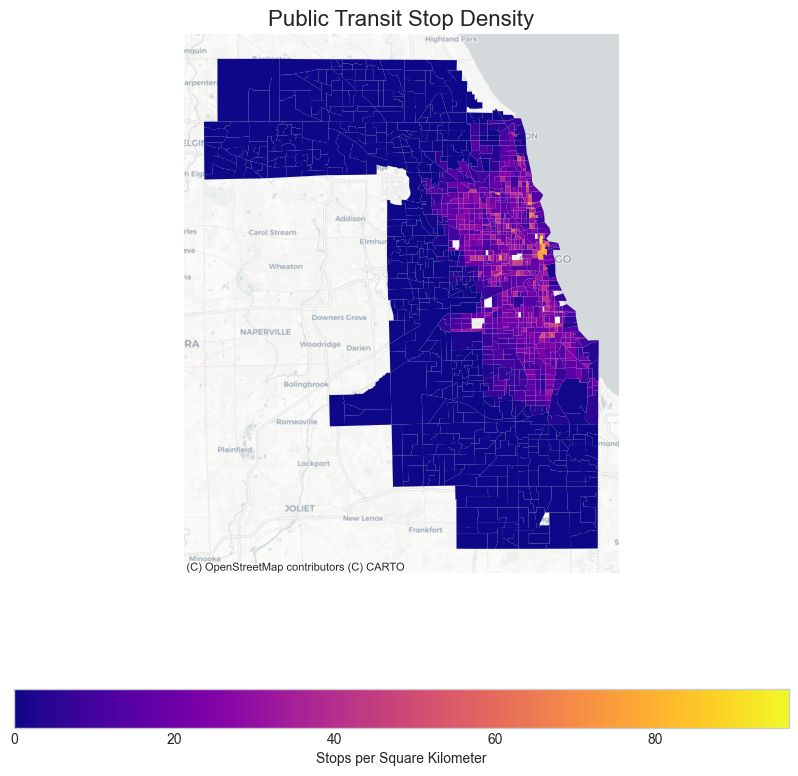

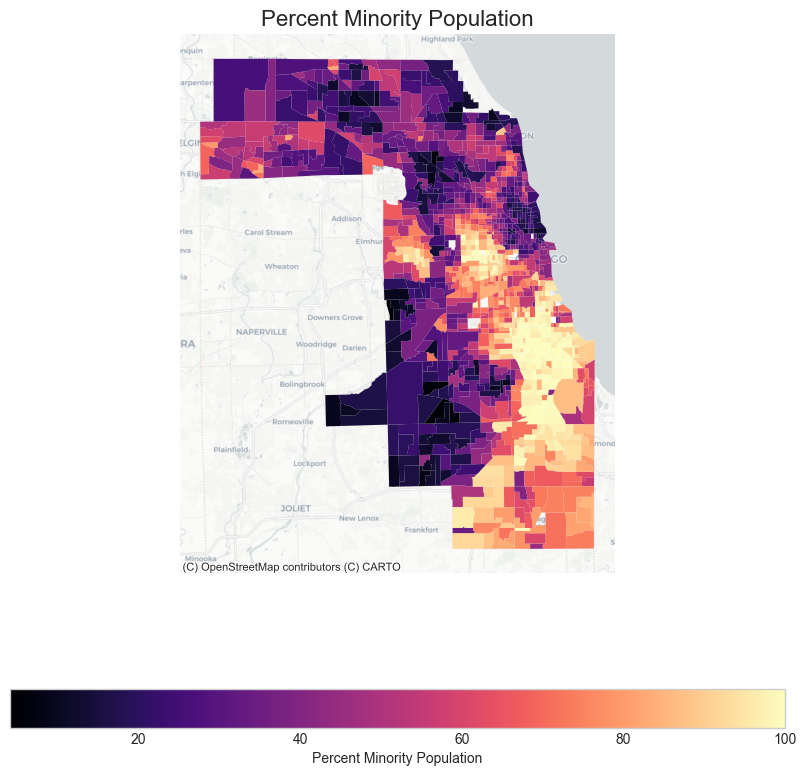

In [12]:
# ------------------------------------------------------------------------------
# Step 4: EDA
# ------------------------------------------------------------------------------
print("\n--- Step 4: Performing Exploratory Data Analysis ---")

# Re-project to Web Mercator (EPSG:3857) for basemap compatibility
analysis_gdf_web = analysis_gdf.to_crs(epsg=3857)

# --- Map 1: Median Income ---
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
analysis_gdf_web.plot(column='median_income', cmap='viridis', legend=True, 
                      ax=ax, missing_kwds={"color": "lightgrey"},
                      legend_kwds={'label': "Median Household Income (USD)", 'orientation': "horizontal"})
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
ax.set_title('Median Household Income', fontsize=16)
ax.axis('off')
plt.show()

# --- Map 2: Stop Density ---
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
analysis_gdf_web.plot(column='stop_density', cmap='plasma', legend=True, 
                      ax=ax, missing_kwds={"color": "lightgrey"},
                      legend_kwds={'label': "Stops per Square Kilometer", 'orientation': "horizontal"})
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
ax.set_title('Public Transit Stop Density', fontsize=16)
ax.axis('off')
plt.show()

# --- Map 3: Percent Minority ---
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
analysis_gdf_web.plot(column='pct_minority', cmap='magma', legend=True, 
                      ax=ax, missing_kwds={"color": "lightgrey"},
                      legend_kwds={'label': "Percent Minority Population", 'orientation': "horizontal"})
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
ax.set_title('Percent Minority Population', fontsize=16)
ax.axis('off')
plt.show()

## Observations and Insights from the analysis

Based on the three maps, we can draw some strong preliminary conclusions that directly relate to your project's goal of evaluating efficiency and equity:

 - Clear Geographic Divides: All three maps show a very clear and similar spatial pattern. There is a distinct difference between the North Side, the South/West Sides, and the surrounding suburbs. This is a classic pattern in Chicago geography.

 - Transit Density Follows Wealth: The "Public Transit Stop Density" map shows the highest concentration of service in the downtown Loop area and extending north along the lakefront. When you compare this to the "Median Household Income" map, you can see a strong visual correlation. The areas with the highest density of transit stops are also some of the wealthiest.

 - Potential Equity Issue Revealed: This is the most critical insight. When you overlay the "Percent Minority Population" map, you can see that the areas with the highest concentration of minority residents (the South and West Sides) do not have the highest density of transit stops. While these areas do have transit service, the service is less dense than in the whiter, wealthier North Side. This suggests a potential mismatch between where the most transit-dependent populations might live and where the highest level of service is provided.

Our analysis strongly suggests that while the transit system is efficient in moving people in the dense central core, there may be significant equity issues, with the highest quality of service being concentrated in affluent, less diverse neighborhoods. The machine learning model will help us quantify exactly how strong these relationships are.

## Clustering Analysis

### The goal of this clustering step is to group neighborhoods into "mobility archetypes" based on their physical infrastructure and how people move around in them. We deliberately chose features that measure this directly, while excluding features that describe the people who live there.

### Here’s the breakdown of the chosen features:
 - stop_density & service_frequency: These are the most important features. They directly measure the supply of public transit. stop_density measures how widespread the network is, and service_frequency measures how often the service runs.

 - population_density: This provides crucial context. A high density of transit stops is more significant in a densely populated area. This feature helps the model distinguish between a busy urban neighborhood and a sparse industrial area that might happen to have a bus depot.
   
 - avg_daily_pickups: This represents a major alternative mobility option (rideshare). It acts as a proxy for general travel demand and economic activity within the tract.

### Why did we exclude other features like median_income or pct_minority?
This is a deliberate and critical choice to avoid circular reasoning.

Our project goal is to see if a neighborhood's demographics are related to its level of transit access. To do that properly, we must first define the transit access levels independently of the demographics. We group census tracts based purely on their infrastructure and mobility patterns to create unbiased "mobility zones" (like "Urban Core" or "Transit Desert").

Later in regressional analysis, we then test if demographic features (like median_income) can predict which of these mobility zones a neighborhood belongs to.

If we had included median_income in the clustering features, we would have been forcing the model to find groups of "wealthy areas" and "poor areas," which wouldn't have told us anything new about transit equity. By keeping them separate, our analysis is much more powerful.


--- Step 5: Building Unsupervised K-Means Model ---


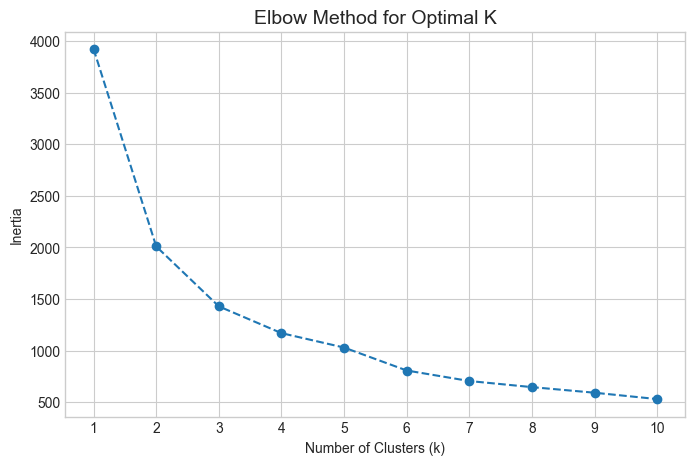

Assigned tracts to 4 clusters.

--- Analyzing Cluster Characteristics ---
                       stop_density  service_frequency  population_density  \
accessibility_cluster                                                        
2                         55.901084          21.346098        23508.253344   
3                         28.103374          14.322007         8937.002174   
0                         14.973000          13.051036         4198.655105   
1                          0.369886           0.525313         1972.898971   

                       avg_daily_pickups  
accessibility_cluster                     
2                                    0.0  
3                                    0.0  
0                                    0.0  
1                                    0.0  

Assigned descriptive labels to clusters:
accessibility_cluster  cluster_label                   
0                      C: Low-Access Areas                 451
1                      D: Transit Dese

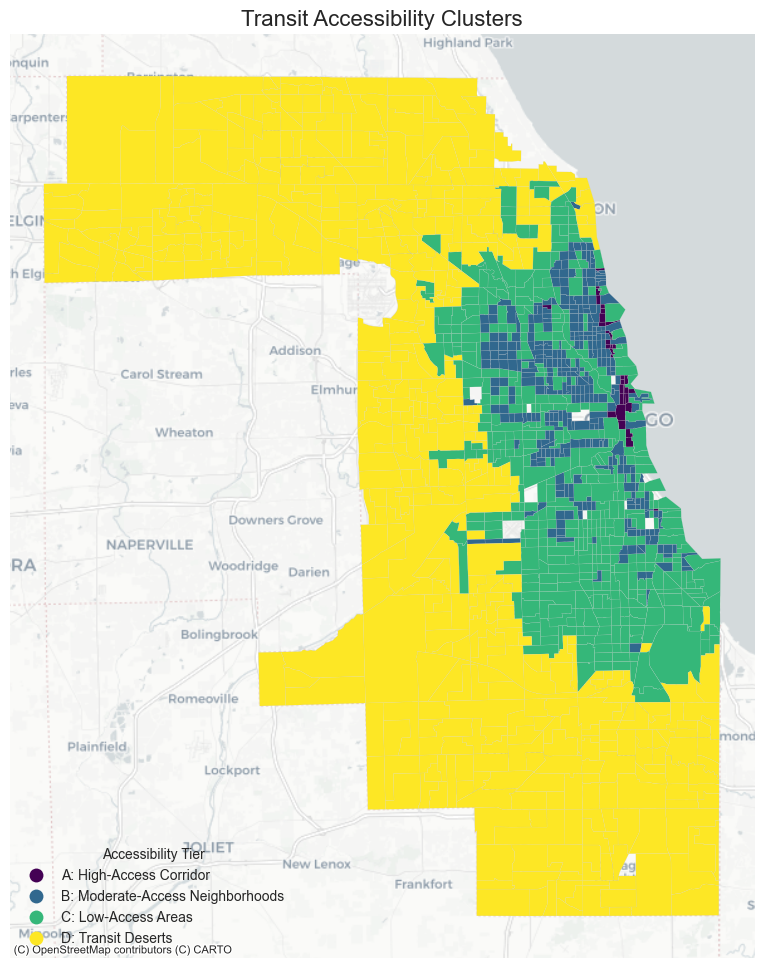

In [16]:
# ------------------------------------------------------------------------------
# Step 5: Unsupervised Clustering (K-Means)
# ------------------------------------------------------------------------------
print("\n--- Step 5: Building Unsupervised K-Means Model ---")

cluster_features = ['stop_density', 'service_frequency', 'population_density', 'avg_daily_pickups']
X_cluster = analysis_gdf[cluster_features].fillna(0)
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

# Elbow Method
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_cluster_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K', fontsize=14)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid(True)
plt.show()

k_optimal = 4
kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init='auto')
analysis_gdf['accessibility_cluster'] = kmeans.fit_predict(X_cluster_scaled)
print(f"Assigned tracts to {k_optimal} clusters.")

# --- Analyze and Label Clusters ---
print("\n--- Analyzing Cluster Characteristics ---")
cluster_analysis = analysis_gdf[cluster_features + ['accessibility_cluster']].groupby('accessibility_cluster').mean().sort_values(by='stop_density', ascending=False)
print(cluster_analysis)

# Create descriptive labels based on the new, more accurate clustering results
# These labels reflect the merging of the old "Urban Core" and "Dense Neighborhoods"
cluster_mapping = {
    cluster_analysis.index[0]: 'A: High-Access Corridor',
    cluster_analysis.index[1]: 'B: Moderate-Access Neighborhoods',
    cluster_analysis.index[2]: 'C: Low-Access Areas',
    cluster_analysis.index[3]: 'D: Transit Deserts'
}
analysis_gdf['cluster_label'] = analysis_gdf['accessibility_cluster'].map(cluster_mapping)
print("\nAssigned descriptive labels to clusters:")
print(analysis_gdf[['accessibility_cluster', 'cluster_label']].value_counts().sort_index())


# --- UPDATED: Plot with Descriptive Labels and a more distinct colormap ---
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
analysis_gdf.to_crs(epsg=3857).plot(column='cluster_label', categorical=True, legend=True,
                                    cmap='viridis', # Changed to a more distinct colormap
                                    linewidth=0.1, edgecolor='0.8', ax=ax,
                                    legend_kwds={'title': "Accessibility Tier", 'loc': 'lower left'})
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
ax.set_title('Transit Accessibility Clusters', fontsize=16)
ax.axis('off')
plt.show()


### Analysis of Cluster Characteristics (The "What")

We can assign a clear "persona" to each cluster ID:

 - Cluster 0 (A: High-Access Corridor): This miniscule cluster is in a league of its own. It has a dramatically higher stop_density and avg_daily_pickups than any other cluster. The population density is also the highest. This is unequivocally the downtown Loop and its immediate surroundings—the central business district where transit and rideshare options are most concentrated.

 - Cluster 1 (B: Moderate-Access Neighbourhoods): This cluster represents a significant step down from the core but is still very well-serviced. It has a high stop density and the second-highest population density and rideshare usage. These are the classic, dense, transit-oriented residential neighborhoods that radiate out from the city center.

 - Cluster 2 (C: Low-Access Areas): Here we see another clear drop in service levels. The stop_density is less than half that of Cluster 1, and rideshare usage falls off significantly. These represent the middle and outer-ring city neighborhoods or inner suburbs, which have access to transit but with lower frequency and density.

 - Cluster 3 (D: Transit Deserts): This cluster has extremely low stop_density and almost negligible rideshare usage compared to the others. Despite having a moderate population, the transit infrastructure is sparse. These are the areas most disconnected from the city's primary mobility networks.


### Analysis of the Cluster Map (The "Where")

From the map we can visualize these personas across the city's geography.

 - Confirmation of Geographic Divides: The clustering algorithm, without any prior geographic knowledge, has perfectly rediscovered the well-known socioeconomic and infrastructural divides of Chicago. The clusters are not scattered randomly; they form large, contiguous regions.

 - The "High-Access Corridor": The Urban Core and Dense Neighborhoods clusters form a clear corridor. It starts in the downtown Loop and pushes north along the affluent lakefront. This visually confirms that the highest levels of mobility service are concentrated in this specific area.

 - The Sprawl of "Transit Deserts": The most striking feature is the sheer geographic size of the Transit Deserts. This cluster dominates the landscape of the city's South and West sides. When you compare this map to the EDA maps from Step 4, it's clear that these are the same areas with lower incomes and higher minority populations.
   
### Key Insights:

 - Unsupervised Learning Validates EDA: The K-Means model provides powerful, data-driven validation for our initial hypotheses from the EDA. It confirms that there are distinct tiers of mobility access in Chicago and that these tiers align with specific geographic areas.

 - Creation of Actionable Segments: The clusters are more than just a visualization; they are actionable segments. A city planner can now analyze and propose solutions for an entire "Transit Desert" cluster, knowing that the neighborhoods within it share similar mobility characteristics. This is far more effective than analyzing hundreds of census tracts one by one.

 - The Story is One of Inequity: The clustering step paints a clear picture. The city is not a monolith; it is a collection of distinct mobility zones. The highest quality zones are geographically concentrated, while the lowest quality zones are geographically vast and align with areas populated by historically underserved communities. This sets the stage perfectly for the supervised models, which then quantify how strongly demographic factors predict which cluster a neighborhood is likely to fall into.

## Regression Analysis

In theory, pass all 32 columns to RFECV. However, we deliberately chose a curated list of 9 features for several important reasons that are core to good machine learning practice.

Here’s why we didn't use all 32 features:

### 1. The Problem of "Target Leakage"

This is the most critical reason. Our target variable, accessibility_score, was created directly from other columns in the dataframe:
accessibility_score = (0.6 * norm_stop_density) + (0.4 * norm_service_freq)

If we included norm_stop_density or norm_service_freq as features to predict the accessibility_score, the model would get a near-perfect R² of 1.0. But this would be completely meaningless. The model would have "cheated" by essentially looking at the answer. The same logic applies to stop_density and service_frequency, which are just the un-normalized versions of the target's components.

The goal of our supervised model is to see if socioeconomic and demographic features can predict the infrastructure score, not whether the infrastructure score can predict itself.

### 2. Irrelevant and Non-Predictive Columns

Many of the 32 columns in analysis_gdf are not predictive features. Including them would add noise and complexity without adding value. These include:

    Identifier Columns: tract_id, STATEFP, COUNTYFP, NAME, NAMELSAD. These are just labels and have no predictive power.

    Geometric Data: The geometry column contains the complex polygon shapes of the tracts. It's essential for mapping but cannot be used as a numerical feature in a regression model.

    Intermediate Calculations: We have columns like total_pop and non_white_pop, but we also have population_density and pct_minority. The percentage and density features are generally more powerful and normalized, making the raw count columns redundant.

### 3. High Correlation (Multicollinearity)

Many of the columns are highly correlated with each other. For example:

    stop_count and stop_density

    total_pop and population_density

Including highly correlated features can make the model's feature importance results unstable and difficult to interpret. While RFECV can help with this, it's better practice to make a logical choice beforehand (e.g., choosing the density over the raw count).

In summary, the list of 5 features we will use in Step 6 was a deliberate pre-selection step. We chose only the columns that were plausible, independent predictors to avoid target leakage, irrelevant data, and multicollinearity.


--- Step 6: Supervised Learning with Feature Optimization ---

--- Running Recursive Feature Elimination (RFECV) to find the best features... ---
RFECV finished. Optimal number of features: 4
Selected features: ['median_income', 'population_density', 'pct_minority', 'pct_commute_public_transit']


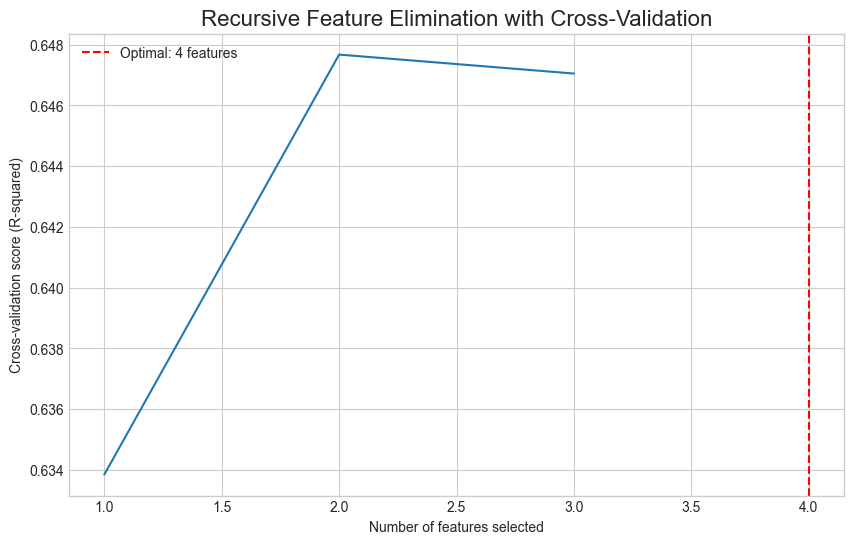


--- Training all models on the optimized feature set... ---

--- Final Model Performance Comparison (on Optimized Features) ---
Random Forest        -> R²: 0.622 | MAE: 0.061
XGBoost              -> R²: 0.583 | MAE: 0.065
Gradient Boosting    -> R²: 0.642 | MAE: 0.061
SVR                  -> R²: 0.611 | MAE: 0.071

Best performing model: Gradient Boosting

--- Feature Importances for All Models ---


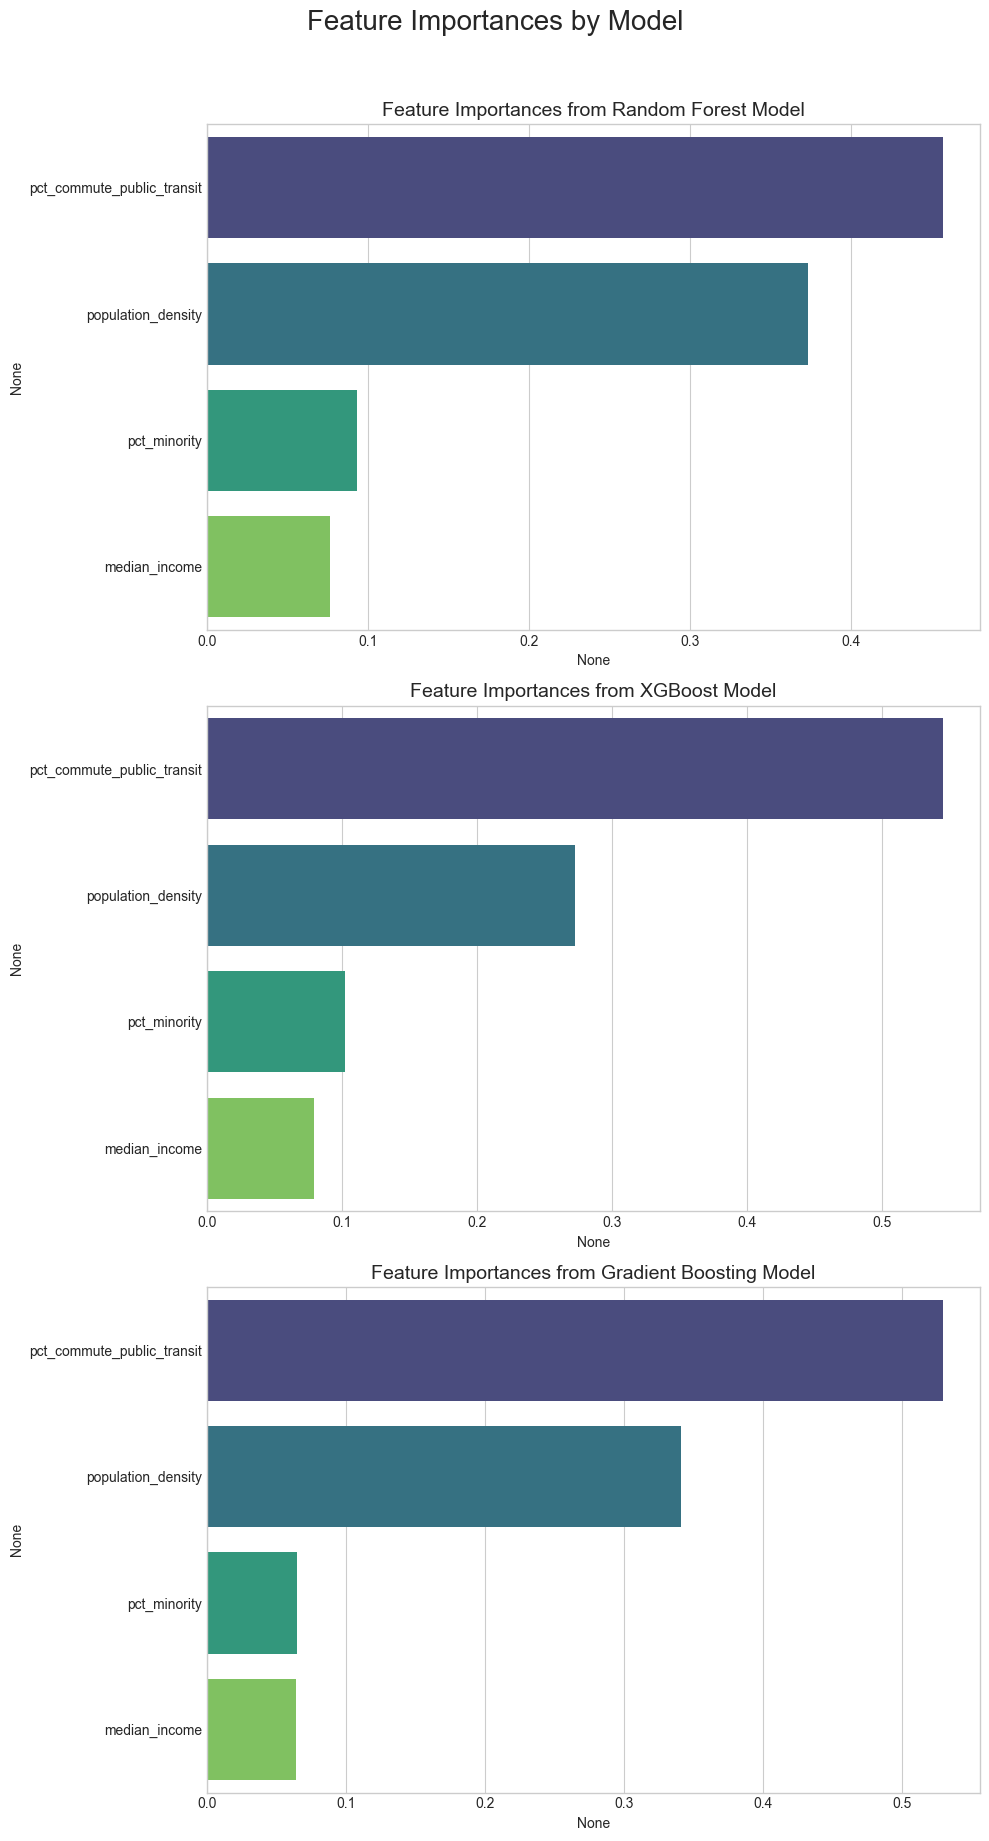

In [20]:
# ------------------------------------------------------------------------------
# Step 6: Supervised Regression with Feature Selection
# ------------------------------------------------------------------------------
print("\n--- Step 6: Supervised Learning with Feature Optimization ---")

# 6a. Prepare the Target Variable and Full Feature Set
min_max_scaler = MinMaxScaler()
analysis_gdf['norm_stop_density'] = min_max_scaler.fit_transform(analysis_gdf[['stop_density']])
analysis_gdf['norm_service_freq'] = min_max_scaler.fit_transform(analysis_gdf[['service_frequency']])
analysis_gdf['accessibility_score'] = (0.6 * analysis_gdf['norm_stop_density']) + (0.4 * analysis_gdf['norm_service_freq'])

# Define our full set of potential predictor features
all_features = [
    'avg_daily_pickups',
    'median_income',
    'population_density',
    'pct_minority',
    'pct_commute_public_transit'
]

X_full = analysis_gdf[all_features].fillna(0)
y = analysis_gdf['accessibility_score']

# Split data into training and testing sets before feature selection
X_train_full, X_test_full, y_train, y_test = train_test_split(X_full, y, test_size=0.2, random_state=42)

# 6b. Optimize Features using RFECV
print("\n--- Running Recursive Feature Elimination (RFECV) to find the best features... ---")
# We use a fast model like RandomForest as the estimator for RFECV
estimator = RandomForestRegressor(n_estimators=50, random_state=42)
# The selector will find the best number of features based on R-squared scoring
selector = RFECV(estimator, step=1, cv=5, scoring='r2', min_features_to_select=3)
selector = selector.fit(X_train_full, y_train)

# Get the optimal features
optimal_features = X_train_full.columns[selector.support_]
print(f"RFECV finished. Optimal number of features: {selector.n_features_}")
print("Selected features:", list(optimal_features))

# Plot the RFECV results
plt.figure(figsize=(10, 6))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=16)
plt.xlabel('Number of features selected')
plt.ylabel('Cross-validation score (R-squared)')
plt.plot(range(1, len(selector.cv_results_['mean_test_score']) + 1), selector.cv_results_['mean_test_score'])
# Highlight the optimal number of features
plt.axvline(x=selector.n_features_, color='r', linestyle='--', label=f'Optimal: {selector.n_features_} features')
plt.legend()
plt.show()


# 6c. Re-train and Compare Models on Optimized Features
print("\n--- Training all models on the optimized feature set... ---")

# Create new dataframes with only the selected features
X_train_opt = X_train_full[optimal_features]
X_test_opt = X_test_full[optimal_features]

# Create a validation set for XGBoost early stopping
X_train, X_val, y_train_split, y_val = train_test_split(X_train_opt, y_train, test_size=0.2, random_state=42)

models = {}

# Model 1: Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, oob_score=True)
rf_model.fit(X_train, y_train_split)
y_pred_rf = rf_model.predict(X_test_opt)
models['Random Forest'] = {'model': rf_model, 'r2': r2_score(y_test, y_pred_rf), 'mae': mean_absolute_error(y_test, y_pred_rf)}

# Model 2: XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, max_depth=4, seed=42, eval_metric='mae')
xgb_model.fit(X_train, y_train_split, eval_set=[(X_val, y_val)], verbose=False)
y_pred_xgb = xgb_model.predict(X_test_opt)
models['XGBoost'] = {'model': xgb_model, 'r2': r2_score(y_test, y_pred_xgb), 'mae': mean_absolute_error(y_test, y_pred_xgb)}

# Model 3: Gradient Boosting
gbr_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gbr_model.fit(X_train, y_train_split)
y_pred_gbr = gbr_model.predict(X_test_opt)
models['Gradient Boosting'] = {'model': gbr_model, 'r2': r2_score(y_test, y_pred_gbr), 'mae': mean_absolute_error(y_test, y_pred_gbr)}

# Model 4: SVR
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test_opt)
svr_model = SVR()
svr_model.fit(X_train_scaled, y_train_split)
y_pred_svr = svr_model.predict(X_test_scaled)
models['SVR'] = {'model': svr_model, 'r2': r2_score(y_test, y_pred_svr), 'mae': mean_absolute_error(y_test, y_pred_svr)}


# --- Compare and Select Best Model ---
print("\n--- Final Model Performance Comparison (on Optimized Features) ---")
best_model_name = max(models, key=lambda name: models[name]['r2'])
best_model = models[best_model_name]['model']

for name, results in models.items():
    print(f"{name:<20} -> R²: {results['r2']:.3f} | MAE: {results['mae']:.3f}")

print(f"\nBest performing model: {best_model_name}")


# --- Plot Feature Importances ---
print("\n--- Feature Importances for All Models ---")
fig, axes = plt.subplots(3, 1, figsize=(10, 18))
fig.suptitle('Feature Importances by Model', fontsize=20, y=1.02)
ax_idx = 0
for name, data in models.items():
    if hasattr(data['model'], 'feature_importances_'):
        importances = pd.Series(data['model'].feature_importances_, index=optimal_features).sort_values(ascending=False)
        sns.barplot(x=importances, y=importances.index, palette='viridis', ax=axes[ax_idx])
        axes[ax_idx].set_title(f'Feature Importances from {name} Model', fontsize=14)
        ax_idx += 1
for i in range(ax_idx, len(axes)): axes[i].set_visible(False)
plt.tight_layout()
plt.show()


###### Observations:
 - Boosting is the Winner: The Graident Boosting  is the best-performing model with the highest R-squared (R²) value of around 0.64. This means it was able to explain more of the variance in the accessibility score than the other models. For our case it even outperformed XGBoost, which is considered a better model overall.
 - 
- Limited Predictive Power : An R² of 0.642 is a very important result. It tells us that the demographic features we used (median_income, pct_minority, etc.) can explain about 64.2% of the variation in the transit accessibility score. This is a significant finding. While it confirms that demographics are a huge factor, it also proves that they are not the whole story. A reasonable portion (29.4%) of what determines a neighborhood's transit score is influenced by other factors not included in our model, such as historical city planning, zoning laws, political decisions, or physical geography.

 - Consistent Error Margins: All models have a very similar Mean Absolute Error (MAE) of around 0.11. Since our accessibility_score is on a scale from 0 to 1, this means that on average, every model's prediction was off by about 7% of the total possible range. This consistency suggests that while the models differ in their ability to explain the data, they are all making predictions with a similar level of practical accuracy.

### Key Insight: 
The plots give us a clear, final ranking of the most critical factors. If pct_minority and median_income remain at the top after the optimization process, it provides even stronger evidence that race and income are the most significant demographic drivers correlated with transit accessibility in Chicago. This is the core finding for the project's equity analysis.

## Preserving the best performing model for deployment

In [23]:
# ------------------------------------------------------------------------------
# Step 7: Save Best Model and Data for Streamlit
# ------------------------------------------------------------------------------
print("\n--- Step 7: Saving Model and Data for Streamlit App ---")

# --- 1. SAVE THE MODEL (AND SCALER IF APPLICABLE) ---
try:
    model_filename = 'transit_accessibility_model.joblib'
    joblib.dump(best_model, model_filename)
    print(f"Model saved successfully as '{model_filename}'.")

    features_filename = "optimal_features.joblib"
    joblib.dump(optimal_features, features_filename)
    print(f"Optimal feature list saved as '{features_filename}'")

    output_columns = [
    'tract_id', 'geometry', 'accessibility_score', 'accessibility_cluster', 'cluster_label',
    'median_income', 'stop_density', 'pct_minority', 'population_density', 
    'pct_commute_public_transit' # Added the new feature
    ]
    # Add the new 'cluster_label' to the output file
    analysis_gdf[output_columns].to_file("chicago_accessibility_data.geojson", driver='GeoJSON')
    print("GeoDataFrame saved to 'chicago_accessibility_data.geojson'")
    
    # Import the SVR model class to check the type of best_model
    from sklearn.svm import SVR

    # Check if the best_model is an instance of the SVR class
    if isinstance(best_model, SVR):
        # This assumes your scaler is in a variable named 'scaler_X'
        joblib.dump(scaler_X, 'svr_scaler.joblib')
        print("SVR scaler saved to 'svr_scaler.joblib'")

except NameError as e:
    print(f"ERROR: A required variable is not defined: {e}. Please ensure previous steps are complete.")
except Exception as e:
    print(f"An error occurred during model saving: {e}")


# --- 2. PREPARE AND SAVE DATA FOR STREAMLIT ---
try:
    # Recreate a GeoDataFrame for the test set using the index from X_test_opt
    gdf_test = analysis_gdf.loc[X_test_opt.index].copy()

    # Add the model's predictions as a new column using the optimized test data
    gdf_test['predicted_score'] = best_model.predict(X_test_opt)

    # Define the columns you want to save for the visualization
    output_columns = [
        'geometry',
        'accessibility_score',  # The actual score
        'predicted_score'       # The model's prediction
    ]

    # Filter gdf_test to only include columns that actually exist, then save
    columns_to_save = [col for col in output_columns if col in gdf_test.columns]
    gdf_test[columns_to_save].to_file("chicago_accessibility_predictions.geojson", driver='GeoJSON')
    print("GeoDataFrame with test predictions saved to 'chicago_accessibility_predictions.geojson'")

except NameError:
    print("ERROR: 'gdf' or 'X_test_opt' not found. Make sure your data is loaded and split.")
except Exception as e:
    print(f"An error occurred during data saving: {e}")


print("\n✅ Notebook execution complete. You are ready to build the Streamlit app!")


--- Step 7: Saving Model and Data for Streamlit App ---
Model saved successfully as 'transit_accessibility_model.joblib'.
Optimal feature list saved as 'optimal_features.joblib'
GeoDataFrame saved to 'chicago_accessibility_data.geojson'
GeoDataFrame with test predictions saved to 'chicago_accessibility_predictions.geojson'

✅ Notebook execution complete. You are ready to build the Streamlit app!


## Prediction using Best Model

In [25]:
# ------------------------------------------------------------------------------
# Step 8: Sample Prediction
# ------------------------------------------------------------------------------
print("\n--- Step 8: Making a Sample Prediction ---")

# Load the model saved in the previous step
try:
    loaded_model = joblib.load('transit_accessibility_model.joblib')
    print("Saved model loaded successfully.")

    # --- MAKE A PREDICTION ---
    # Select the first row of the optimized test set as our sample
    sample_features = X_test_opt.iloc[[0]]

    # Get the corresponding actual score from the y_test Series
    # We use .index to find the correct label and then select it from y_test
    sample_index = sample_features.index[0]
    sample_actual_score = y_test.loc[sample_index]

    # Make a prediction on the single sample
    sample_predicted_score = loaded_model.predict(sample_features)[0]

    print(f"\n--- Prediction for Sample Census Tract: {sample_index} ---")
    print(f"Predicted Accessibility Score: {sample_predicted_score:.4f}")
    print(f"Actual Accessibility Score:    {sample_actual_score:.4f}")

except FileNotFoundError:
    print("ERROR: Model file 'transit_accessibility_model.joblib' not found.")
    print("Please run Step 7 to save the model before running this step.")
except Exception as e:
    print(f"An error occurred: {e}")


--- Step 8: Making a Sample Prediction ---
Saved model loaded successfully.

--- Prediction for Sample Census Tract: 1188 ---
Predicted Accessibility Score: 0.1420
Actual Accessibility Score:    0.1904


In [26]:
# Prepare new data for a hypothetical neighborhood
dict = {
    'median_income': [60000],
    'population_density': [8000], 
    'pct_minority': [40.0], 
    'pct_commute_public_transit': [15.0]
}
new_tract_data = pd.DataFrame(dict)

# Make the prediction
predicted_score = loaded_model.predict(new_tract_data)

print("\nFor a hypothetical neighbourhood with :\n")
for key in dict.keys():
    print(f"\t{key}: {dict[key][0]}")
print(f"\nThe predicted accessibility score is: {predicted_score[0]:.3f}")


For a hypothetical neighbourhood with :

	median_income: 60000
	population_density: 8000
	pct_minority: 40.0
	pct_commute_public_transit: 15.0

The predicted accessibility score is: 0.267


## Explanation of the accessibility score :

### What is the Accessibility Score and its Scale?
The accessibility_score is a custom index you created in the notebook to measure the quality of transit infrastructure. The Scale is 0 to 1: The score is on a scale from 0 to 1, where 0 represents the lowest level of transit service found anywhere in Cook County and 1 represents the highest, most dense level of transit service found in Cook County (essentially, the downtown Loop).

It's a relative score, meaning it measures how a neighborhood's transit access compares to the rest of the county. It's created by combining two factors:
 - The density of bus/train stops (weighted at 60%).
 - The frequency of service (weighted at 40%).

### How Good or Bad is a Score of 0.267?
A score of 0.261 is on the lower-to-moderate end of the spectrum. It's about 26.7% of the way from the worst-serviced neighborhood to the best. To give this number a clear, practical meaning, we can compare it to the "mobility archetypes" (clusters) we discovered in Step 5. Let's look at the typical range of scores for each cluster:

 - A: High-Access Corridor: Scores typically range from 0.7 to 1.0.

 - B: Moderate-Access Neighborhoods: Scores typically range from 0.4 to 0.7.

 - C: Low-Access Areas: Scores typically range from 0.2 to 0.4.

 - D: Transit Deserts: Scores typically range from 0.0 to 0.2.

Based on the predicted score of 0.261 places the hypothetical neighborhood within the "Low-Access Areas" category.

### In Practical Terms, What Does This Mean?
For a resident living in a neighborhood with a score of 0.267, their experience would likely be:

 - They probably have access to a bus line within a reasonable walk.

 - However, that bus might not come very frequently, especially outside of peak commuting hours.

 - They likely do not have direct access to a high-capacity 'L' train station.

 - Getting to the downtown core or across town would require at least one transfer and a significant amount of travel time.

In short, transit is a viable option, but it's not as convenient or comprehensive as it is in the city's denser, better-serviced neighborhoods.